In [1]:
import gymnasium as gym
import minigrid
from minigrid.wrappers import ImgObsWrapper, RGBImgPartialObsWrapper, RGBImgObsWrapper, ReseedWrapper
from minigrid.core.constants import COLOR_NAMES
from minigrid.core.grid import Grid
from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Door, Goal, Key, Wall
from minigrid.manual_control import ManualControl
from minigrid.minigrid_env import MiniGridEnv
import seaborn as sns
# sns.set(rc={'figure.figsize':(11.7,8.27)})
import pandas as pd
from IPython.display import Video
import matplotlib.pyplot as plt
import numpy as np
import cv2
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical, Beta
from torch.autograd import Function
from utils import reparameterize

device = "cuda:0"

pygame 2.5.2 (SDL 2.28.2, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
arr1 = np.zeros((64, 64, 3))
arr2 = np.zeros((64, 64, 3))
np.savez("test.npz", obs=[arr1, arr2])

In [4]:
test = np.load("test.npz")
list(test.values())[0].shape

(2, 64, 64, 3)

In [3]:
# Models for carracing games
class Encoder(nn.Module):
    def __init__(self, class_latent_size = 8, content_latent_size = 32, input_channel = 3, flatten_size = 1024):
        super(Encoder, self).__init__()
        self.class_latent_size = class_latent_size
        self.content_latent_size = content_latent_size
        self.flatten_size = flatten_size

        self.main = nn.Sequential(
            nn.Conv2d(input_channel, 32, 4, stride=2), nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2), nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2), nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2), nn.ReLU()
        )

        self.linear_mu = nn.Linear(flatten_size, content_latent_size)
        self.linear_logsigma = nn.Linear(flatten_size, content_latent_size)
        self.linear_classcode = nn.Linear(flatten_size, class_latent_size) 

    def forward(self, x):
        x = self.main(x)
        x = x.view(x.size(0), -1)
        mu = self.linear_mu(x)
        logsigma = self.linear_logsigma(x)
        classcode = self.linear_classcode(x)

        return mu, logsigma, classcode

    def get_feature(self, x):
        mu, logsigma, classcode = self.forward(x)
        return mu


class Decoder(nn.Module):
    def __init__(self, latent_size = 32, output_channel = 3, flatten_size=1024):
        super(Decoder, self).__init__()

        self.fc = nn.Linear(latent_size, flatten_size)

        self.main = nn.Sequential(
            nn.ConvTranspose2d(flatten_size, 128, 5, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 5, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 6, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 6, stride=2), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.unsqueeze(-1).unsqueeze(-1)
        x = self.main(x)
        return x


# DisentangledVAE here is actually Cycle-Consistent VAE, disentangled stands for the disentanglement between domain-general and domain-specifc embeddings 
class DisentangledVAE(nn.Module):
    def __init__(self, class_latent_size = 8, content_latent_size = 32, img_channel = 3, flatten_size = 1024):
        super(DisentangledVAE, self).__init__()
        self.encoder = Encoder(class_latent_size, content_latent_size, img_channel, flatten_size)
        self.decoder = Decoder(class_latent_size + content_latent_size, img_channel, flatten_size)

    def forward(self, x):
        mu, logsigma, classcode = self.encoder(x)
        contentcode = reparameterize(mu, logsigma)
        latentcode = torch.cat([contentcode, classcode], dim=1)

        recon_x = self.decoder(latentcode)

        return mu, logsigma, classcode, recon_x


def preprocess(x):
    # x = cv2.resize(x, (40, 40))
    x = torch.from_numpy(x).float() / 255.0
    if len(x.shape) == 3:
        x = x.permute(2, 0, 1).unsqueeze(0).to(device)
    else:
        x = x.permute(0, 3, 1, 2).to(device)
    return x

In [4]:
encoder = Encoder().to(device)
cycleVAE = DisentangledVAE().to(device)

In [5]:
cycleVAE(tensor_obs)

NameError: name 'tensor_obs' is not defined

In [10]:
car1_0 = np.load('data/carracing_data_full/car1/1.npz')
d = list(car1_0.values())[0]
list(car1_0.keys())

['obs']

In [95]:
car2_1 = np.load('data/carracing_data_full/car2/1.npz')
d1 = list(car2_1.values())[0]

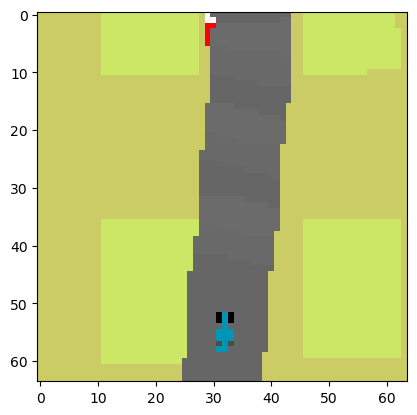

In [96]:
plt.imshow(d1[210])

In [ ]:
car1_0 = np.load('data/carracing_data_full/car1/0.npz')
print(len(list(car1_0.values())[0]))

In [ ]:
car1_0 = np.load('data/carracing_data_full/car1/0.npz')
print(len(list(car1_0.values())[0]))

In [ ]:
car1_0 = np.load('data/carracing_data_full/car1/0.npz')
print(len(list(car1_0.values())[0]))

In [ ]:
car1_0 = np.load('data/carracing_data_full/car1/0.npz')
print(len(list(car1_0.values())[0]))

# Make 8x8 Minigrid Data

(64, 64, 3)


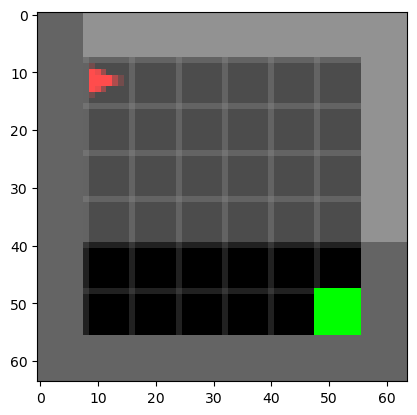

In [6]:
env = gym.make('MiniGrid-Empty-8x8-v0', render_mode="rgb_array")
env = RGBImgObsWrapper(env)
obs, info = env.reset() # This now produces an RGB tensor only
obs = obs["image"]
plt.imshow(obs)
print(obs.shape)

In [7]:
def to_grayscale(image):
    # Convert to grayscale using the luminosity method
    return np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])

def increase_contrast(image, factor=1.5):
    # Increase contrast by scaling the difference from the mean
    mean = np.mean(image)
    return np.clip((1 + factor) * (image - mean) + mean, 0, 255)

def decrease_brightness(image, factor=50):
    # Decrease brightness
    return np.clip(image - factor, 0, 255)

def color_shift_red(image, factor=50):
    # Shift color towards red
    red_channel = image[:,:,0] + factor
    red_channel[red_channel > 255] = 255
    image = np.dstack((red_channel, image[:,:,1], image[:,:,2]))
    image[48:56, 48:56, 0] = 222
    image[48:56, 48:56, 1] = 255
    image[48:56, 48:56, 2] = 239
    return image

def invert_colors(image):
    # Invert image colors
    return 255 - image

def color_shift_blue(image, factor=50):
    # Shift color towards blue
    blue_channel = image[:,:,2] + factor
    blue_channel[blue_channel > 255] = 255
    return np.dstack((image[:,:,0], image[:,:,1], blue_channel))

def color_shift_green(image, factor=50):
    # Shift color towards green
    green_channel = image[:,:,1] + factor
    green_channel[green_channel > 255] = 255
    image = np.dstack((image[:,:,0], green_channel, image[:,:,2]))
    image[48:56, 48:56, 0] = 0
    image[48:56, 48:56, 1] = 0
    image[48:56, 48:56, 2] = 255
    return image

def purple_tint(image, factor=50):
    # Apply a purple tint (red + blue)
    red_channel = image[:,:,0] + factor
    red_channel[red_channel > 255] = 255
    blue_channel = image[:,:,2] + factor
    blue_channel[blue_channel > 255] = 255
    image = np.dstack((red_channel, image[:,:,1], blue_channel))
    image[48:56, 48:56, 0] = 255
    image[48:56, 48:56, 1] = 255
    image[48:56, 48:56, 2] = 153
    return image

def cyan_tint(image, factor=50):
    # Apply a cyan tint (green + blue)
    green_channel = image[:,:,1] + factor
    green_channel[green_channel > 255] = 255
    blue_channel = image[:,:,2] + factor
    blue_channel[blue_channel > 255] = 255
    image = np.dstack((image[:,:,0], green_channel, blue_channel))
    image[48:56, 48:56, 0] = 255
    image[48:56, 48:56, 1] = 132
    image[48:56, 48:56, 2] = 0
    return image

def yellow_tint(image, factor=50):
    # Apply a yellow tint (red + green)
    red_channel = image[:,:,0] + factor
    red_channel[red_channel > 255] = 255
    green_channel = image[:,:,1] + factor
    green_channel[green_channel > 255] = 255
    image = np.dstack((red_channel, green_channel, image[:,:,2]))
    image[48:56, 48:56, 0] = 255
    image[48:56, 48:56, 1] = 201
    image[48:56, 48:56, 2] = 248
    return image

# Assuming 'image' is your numpy array of shape (64, 64, 3)
image = obs

# Apply transformations
grayscale_image = to_grayscale(image)
contrast_image = increase_contrast(image).astype(np.uint8)
brightness_image = decrease_brightness(image)
red_shift_image = color_shift_red(image)
inverted_image = invert_colors(image)
blue_shift_image = color_shift_blue(image)
green_shift_image = color_shift_green(image)
pruple_image = purple_tint(image)
cyan_image = cyan_tint(image)
yellow_image = yellow_tint(image)

# Make sure to convert the grayscale image back to 3 channels if needed for consistency
grayscale_image_3ch = np.stack((grayscale_image,)*3, axis=-1).astype(np.uint8)

concatenated_images = np.concatenate(
    [obs, 
    grayscale_image_3ch, 
    contrast_image, 
    brightness_image, 
    red_shift_image, 
    inverted_image, 
    blue_shift_image,
    green_shift_image, 
    pruple_image,
    cyan_image,
    yellow_image], 1)

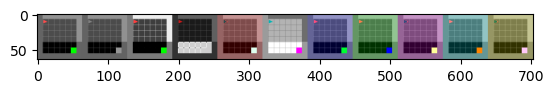

In [8]:
plt.imshow(concatenated_images)

In [5]:
def apply_contrasting_region_color(image, region_coords, color_shift_func, region_color_shift_func, *args, **kwargs):
    """
    Applies a color shift to the whole image and a contrasting color shift to a specified region.
    
    :param image: The original image array.
    :param region_coords: A tuple of slice objects defining the region (e.g., (slice(48,56), slice(48,56))).
    :param color_shift_func: The color shift function to apply to the whole image.
    :param region_color_shift_func: The color shift function to apply specifically to the region for contrast.
    :return: The modified image.
    """
    # Copy the image to avoid modifying the original
    modified_image = image.copy()
    
    # Apply the color shift to the whole image
    modified_image = color_shift_func(modified_image, *args, **kwargs)
    
    # Extract the region
    region = modified_image[region_coords]
    
    # Apply a contrasting color shift to the region
    contrasting_region = region_color_shift_func(region, *args, **kwargs)
    
    # Place the contrasting region back into the image
    modified_image[region_coords] = contrasting_region
    
    return modified_image

# Define contrasting color shift functions for the region
def contrast_color_shift_blue(region, factor=50):
    """Shift the specified region's color towards blue for contrast."""
    region[..., 2] = np.clip(region[..., 2] + factor, 0, 255)  # Increase blue channel
    return region

# Example usage: Apply a red shift to the image and a blue shift to the region
region_coords = (slice(48,56), slice(48,56))  # The specified region
image_with_contrasting_region = apply_contrasting_region_color(
    image, region_coords, color_shift_red, contrast_color_shift_blue, factor=50)

# This will make the specified region stand out with a blue tint against a red-shifted image.


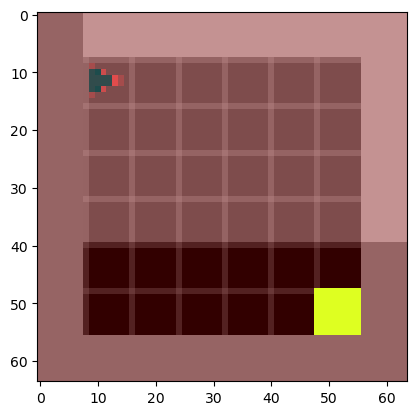

In [6]:
plt.imshow(image_with_contrasting_region)

## Data Generation

In [6]:
from tqdm import tqdm
from collections import deque
encoder = Encoder().to(device)

### Original Domain

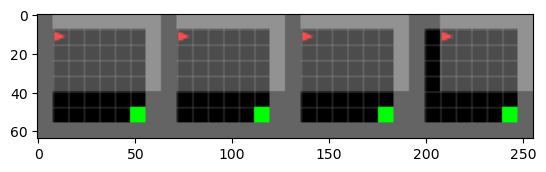

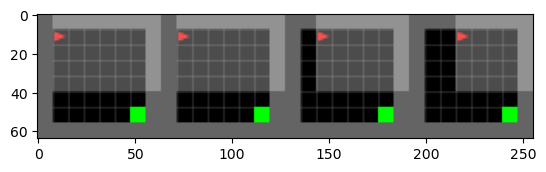

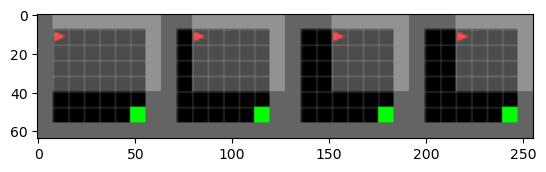

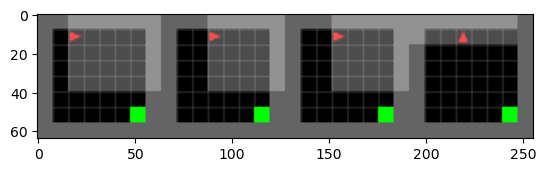

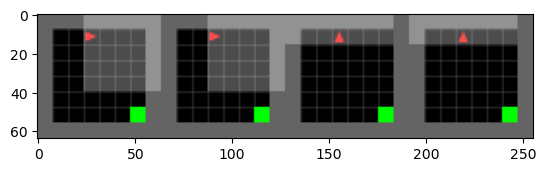

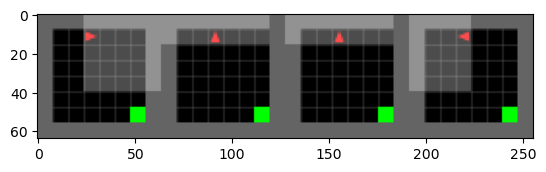

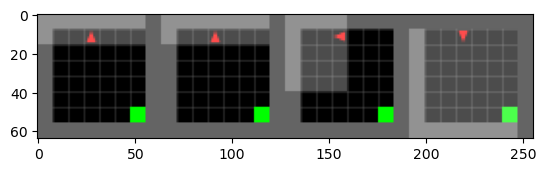

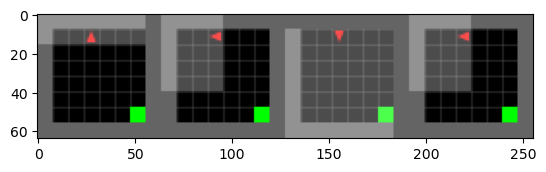

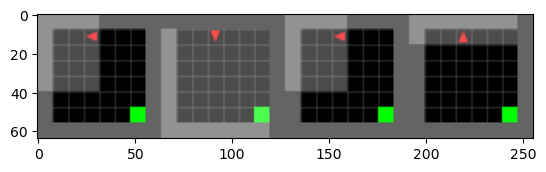

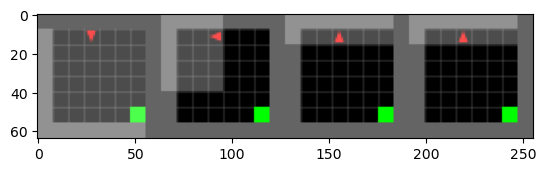

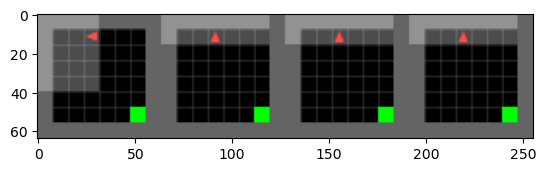

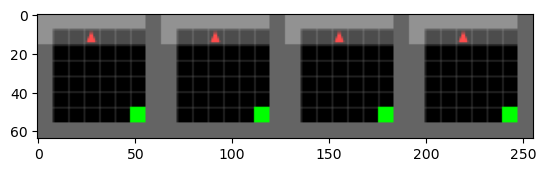

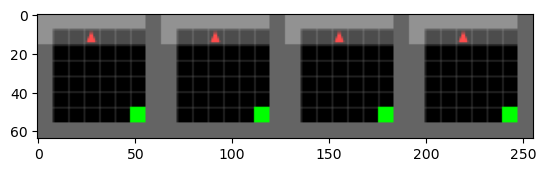

KeyboardInterrupt: 

In [11]:
data_array = []
timestamps = 100_000
obs, info = env.reset()

# Initialize a deque to keep the last 4 observations. 
# If your images are grayscale, shape might be (height, width), and for RGB, shape would be (height, width, channels).
# Adjust the shape according to your environment's observation space.
# For example, if an observation (image) has a shape of 64x64 with 3 channels (RGB), the deque shape will be (4, 64, 64, 3).
# This is just an example, replace (64, 64, 3) with the actual shape of your observations.
feature_queue = deque(maxlen=4)
feature_queue.append()

for t in range(timestamps):
    action = env.action_space.sample()
    obs, r, done, _, _ = env.step(action)
    obs = obs['image']
    
    # Add the current observation to the queue.
    feature_queue.append(obs)
    
    # Stack the images along a new axis to maintain individual image integrity.
    # This will result in an array shape of (4, height, width, channels) if your images are RGB.
    stacked_features = torch.cat(feature_queue, 1)
    print(stacked_features.shape)
    
    if done:
        obs, info = env.reset()
        # Optionally, clear the image queue after reset if you want to start fresh for each episode.
        image_queue.clear()

In [25]:
# np.savez("data/minigrid8x8/grid1/0.npz", obs=data_array)

In [26]:
# test = np.load("data/minigrid8x8/grid1/0.npz")
# test_data = list(test.values())[0]

In [ ]:
### TODO: Append each obs to numpy array and then compress with savez

### Red Domain

In [28]:
red_data_array = []
timestamps = 100_000
obs, info = env.reset()
for t in tqdm(range(timestamps)):
    action = env.action_space.sample()
    obs, r, done, _, _ = env.step(action)
    obs = obs['image']
    obs = color_shift_red(obs)
    red_data_array.append(obs.astype(np.uint8))
    if done:
        obs, info = env.reset()

100%|██████████| 100000/100000 [03:56<00:00, 422.75it/s]


In [29]:
np.savez("data/minigrid8x8/grid2/0.npz", obs=red_data_array)

### Cyan Domain

In [31]:
cyan_data_array = []
timestamps = 100_000
obs, info = env.reset()
for t in tqdm(range(timestamps)):
    action = env.action_space.sample()
    obs, r, done, _, _ = env.step(action)
    obs = obs['image']
    obs = cyan_tint(obs)
    cyan_data_array.append(obs.astype(np.uint8))
    if done:
        obs, info = env.reset()

100%|██████████| 100000/100000 [04:03<00:00, 410.25it/s]


In [32]:
np.savez("data/minigrid8x8/grid3/0.npz", obs=cyan_data_array)

### Purple Domain

In [34]:
pruple_data_array = []
timestamps = 100_000
obs, info = env.reset()
for t in tqdm(range(timestamps)):
    action = env.action_space.sample()
    obs, r, done, _, _ = env.step(action)
    obs = obs['image']
    obs = purple_tint(obs)
    pruple_data_array.append(obs.astype(np.uint8))
    if done:
        obs, info = env.reset()

100%|██████████| 100000/100000 [03:52<00:00, 429.78it/s]


In [42]:
pruple_data_array.shape

(100000, 64, 64, 3)

In [35]:
np.savez("data/minigrid8x8/grid4/0.npz", obs=pruple_data_array)

### Green Domain

In [36]:
green_data_array = []
timestamps = 100_000
obs, info = env.reset()
for t in tqdm(range(timestamps)):
    action = env.action_space.sample()
    obs, r, done, _, _ = env.step(action)
    obs = obs['image']
    obs = color_shift_green(obs)
    green_data_array.append(obs.astype(np.uint8))
    if done:
        obs, info = env.reset()

100%|██████████| 100000/100000 [03:56<00:00, 422.63it/s]


In [37]:
np.savez("data/minigrid8x8/grid5/0.npz", obs=green_data_array)

In [38]:
grid1_0 = np.load('data/minigrid8x8/grid1/0.npz')
list(grid1_0.values())[0].shape

(100000, 64, 64, 3)

In [39]:
grid2_0 = np.load('data/minigrid8x8/grid2/0.npz')
list(grid2_0.values())[0].shape

(100000, 64, 64, 3)

In [40]:
grid3_0 = np.load('data/minigrid8x8/grid3/0.npz')
list(grid3_0.values())[0].shape

(100000, 64, 64, 3)

In [41]:
grid4_0 = np.load('data/minigrid8x8/grid4/0.npz')
list(grid4_0.values())[0].shape

(100000, 64, 64, 3)

In [42]:
grid5_0 = np.load('data/minigrid8x8/grid5/0.npz')
list(grid5_0.values())[0].shape

(100000, 64, 64, 3)